In [1]:
import os
from dotenv import find_dotenv, load_dotenv

try:
    envPath = find_dotenv()

    if not envPath:
        raise ModuleNotFoundError(".env FILE NOT FOUND")
    
    if not load_dotenv(envPath):
        raise EnvironmentError("FAILED TO LOAD .env FILE")
    
    openai_api_key, openai_model = os.environ.get("OPENAI_API_KEY"), os.environ.get("OPENAI_MODEL")

    if not openai_api_key:
        raise ValueError('API KEY NOT FOUND')
    if not openai_model:
        raise ValueError('MODEL NOT FOUND')
except Exception as e:
    print(f"ERROR: {e}")
    openai_api_key, openai_model = None, None

In [2]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition, ToolNode
from typing import Annotated, TypedDict
import operator
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply Tool"""
    return a * b

def divide(a: int, b: int) -> int:
    """Divide Tool"""
    try:
        result = a / b

    except Exception as e:
        print(f"Error: {e}")
        result = 0

    return result

def add(a: int, b: int) -> int:
    """Addition Tool"""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtraction Tool"""
    return a - b

In [9]:
search = DuckDuckGoSearchRun()

In [12]:
search.invoke("Who is the President of Pakistan?")

"Asif Ali Zardari (born July 26, 1955, Karachi, Pakistan) is the president of Pakistan (2008-13; 2024- ) and is the first to have completed a full term in office. Since the assassination of former prime minister Benazir Bhutto, his wife and the leader of the Pakistan People's Party (PPP), he has been the de facto leader of the PPP. His son, Bilawal Bhutto Zardari, also plays a prominent ... Asif Ali Zardari [a] (born 26 July 1955) is a Pakistani politician who is serving as the 14th president of Pakistan since 2024, having held the same office from 2008 to 2013. He is the president of Pakistan People's Party Parliamentarians and was the co-chairperson of Pakistan People's Party from December 2007 until December 2015. [3] PRESIDENT OF THE ISLAMIC REPUBLIC OF P AKISTAN. Mr Asif Ali Zardari was sworn in office on the 10th of March 2024. He is the first President to have been elected twice to this office. Previously, he served as the 11th President of Pakistan from 9th September 2008 to 9t

In [13]:
tools = [add, multiply, subtract, divide, search]

llm = ChatOpenAI(model = openai_model, api_key = openai_api_key)

In [14]:
llmWithTools = llm.bind_tools(tools)

In [15]:
sys_msg = SystemMessage(content = 'You are a helpful assistant tasked with using search and arithmetic operations on inputs.')

In [16]:
def reasoner(state: MessagesState):
    return {'messages': [llmWithTools.invoke([sys_msg] + state['messages'])]}

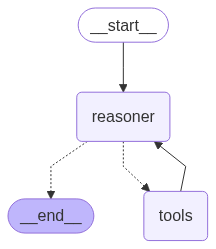

In [18]:
graph = StateGraph(MessagesState)

graph.add_node('reasoner', reasoner)
graph.add_node('tools', ToolNode(tools))

graph.add_edge(START, "reasoner")
graph.add_conditional_edges("reasoner", tools_condition)
graph.add_edge("tools", "reasoner")

reactGraph = graph.compile()
reactGraph

In [24]:
messages = [HumanMessage(content = "What is Imran Khan's age multiplied by the height of Mount Everest?")]

In [25]:
messages = reactGraph.invoke({'messages': messages})

In [26]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is Imran Khan's age multiplied by the height of Mount Everest?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_NH9TiPHjuH5UJifhrZDAS1ke)
 Call ID: call_NH9TiPHjuH5UJifhrZDAS1ke
  Args:
    query: Imran Khan age 2023
  duckduckgo_search (call_0p34ZmS5GgBpX9uhpgUn7ki6)
 Call ID: call_0p34ZmS5GgBpX9uhpgUn7ki6
  Args:
    query: height of Mount Everest in meters
================================= Tool Message =================================
Name: duckduckgo_search

Imran Khan is an antiestablishment politician in Pakistan who in 2022 became the first prime minister to be removed by a parliamentary vote. ... 1952, Lahore, Pakistan (age 72) (Show more) Title / Office: prime minister (2018-2022), Pakistan (Show more) Founder: ... In August 2023 Khan was convicted of corrupt practices after a trial court ... Check this page to read the d

In [27]:
import yfinance as yf

def stockTool(ticker: str) -> float:
    """Stock Tool"""

    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [28]:
stockTool("AAPL")

199.2

In [29]:
def reasoner(state):
    query = state['query']
    messages = state['messages']

    sys_msg = SystemMessage(content = 'You are a helpful assistant tasked with using search, Yahoo Finance and arithmetic operations on inputs.')
    messsge = HumanMessage(content = query)
    messages.append(message)

    result = [llmWithTools.invoke([sys_msg] + messages)]
    return {'messages': result}

In [31]:
tools = [add, subtract, multiply, divide, search, stockTool]

In [32]:
llmWithTools = llm.bind_tools(tools)

In [33]:
class GraphState(TypedDict):
    """Graph State"""
    query: str
    finance: str
    finalAnswer: str

    messages: Annotated[list[AnyMessage], operator.add]

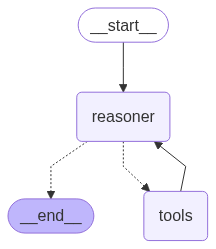

In [34]:
graph = StateGraph(GraphState)

graph.add_node("reasoner", reasoner)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "reasoner")
graph.add_conditional_edges("reasoner", tools_condition)
graph.add_edge("tools", "reasoner")

reactGraph = graph.compile()
reactGraph